In [2]:
import numpy as np
from qiskit import *
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, Aer
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import *
from qiskit.quantum_info import SparsePauliOp, DensityMatrix
from qiskit.opflow import CircuitStateFn, PauliSumOp
from qiskit.opflow import StateFn, PauliExpectation, CircuitSampler
from qiskit_aer import AerSimulator
from qiskit.algorithms.optimizers import GradientDescent, ADAM
from qiskit.quantum_info.operators import Operator
from qiskit.primitives import Estimator
from qiskit.circuit import Parameter




/var/folders/dk/2y17dwn916n0849gyw2c2q3c0000gn/T/ipykernel_1333/387858460.py:7: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import CircuitStateFn, PauliSumOp


In [5]:



def krZ(m,N):
    
    matrix=np.array(1)
    for j in range(N):
        if m==j:
            matrix=np.kron(matrix,ZGate())     
        else:
            matrix=np.kron(matrix,IGate())
    return matrix  

def krId(N):
    matrix=np.array(1)
    for j in range(N):
        matrix=np.kron(matrix,IGate())
    return matrix  


def doublesum(N):
    sum=0
    for i in range(N):
        for j in range(N):
            sum += 2**(i+j) * np.matmul(((krId(N)-krZ(i,N))/2.0),((krId(N)-krZ(j,N))/2.0))
    return sum

def sum(N):
    sum =0
    for i in range(N):
        sum_1 += 2**(i) * ((krId(N)-krZ(i,N))/2.0)
        
    return sum



In [6]:
((krId(2)-krZ(1,2))/2.0)

array([[0., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.]])

In [47]:
krZ(1,2)
    

array([[ 1,  0,  0,  0],
       [ 0, -1,  0,  0],
       [ 0,  0,  1,  0],
       [ 0,  0,  0, -1]])

In [7]:
doublesum(2)
    

array([[0., 0., 0., 0.],
       [0., 4., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 9.]])

In [12]:
doublesum(2)

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 7., 0.],
       [0., 0., 0., 7.]])

In [159]:
m_1

4

## Ansatz


In [3]:
param_1=np.arange(10)

def Ansatz(depth,N,paramnum):

    circuit= QuantumCircuit(N)
    thetas = []
    for idx,l in enumerate(range(paramnum)):
        thetas.append(Parameter('θ_'+str(idx)))
    
    for i in range(depth):
        circuit.barrier()
        counter=0
        
        for j in range(N):
            
            if j+counter <len(thetas):
                circuit.rx(thetas[j+counter],j)
            if j+1+counter <len(thetas):
                circuit.ry(thetas[j+1+counter],j)
            if j+2+counter< len(thetas):
                circuit.rz(thetas[j+2+counter],j)
            else: 
                break
            counter=counter+2
            
                   
                
        for p in range(N):
            circuit.cx(p,(p+1)%N)
            

    return circuit

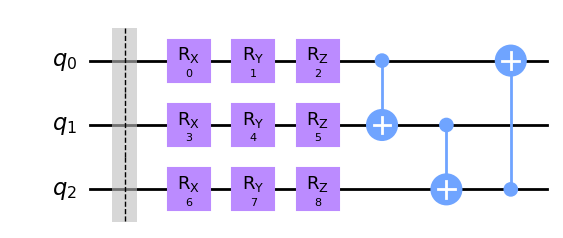

In [346]:
listparam=np.arange(9)
c=Ansatz(1,3,9)
b=c.bind_parameters({c.parameters[i]:listparam[i] for i in range(len(listparam))})
b.draw("mpl")

In [162]:
#just a try with random hamiltonian

op = SparsePauliOp.from_list(
    [
        ("II", -1.052373245772859),
        ("IZ", 0.39793742484318045),
        ("ZI", -0.39793742484318045),
        ("ZZ", -0.01128010425623538),
        ("XX", 0.18093119978423156),
    ]
)



In [163]:
opflow_op = PauliSumOp(op)
opflow_state = CircuitStateFn(state)

/var/folders/dk/2y17dwn916n0849gyw2c2q3c0000gn/T/ipykernel_18026/257205262.py:1: DeprecationWarning: The class ``qiskit.opflow.primitive_ops.pauli_sum_op.PauliSumOp`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  opflow_op = PauliSumOp(op)
/var/folders/dk/2y17dwn916n0849gyw2c2q3c0000gn/T/ipykernel_18026/257205262.py:2: DeprecationWarning: The class ``qiskit.opflow.state_fns.circuit_state_fn.CircuitStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  opflow_state = CircuitStateFn(state)


In [186]:
def costfn(param):
    state=Ansatz(1,3,param)
    
    opflow_op = Operator(Hamiltonian(3,3,2,1))
    opflow_state = CircuitStateFn(state)
    
     
    measurable_expression = StateFn(opflow_op, is_measurement=True).compose(opflow_state)
    expectation = PauliExpectation().convert(measurable_expression)
    simulator = AerSimulator(method="statevector", shots=100)
    circuit_sampler = CircuitSampler(simulator).convert(expectation)
    expectation_value = circuit_sampler.eval().real
    
    return  expectation_value

In [4]:

def costfn2(param):
    state=Ansatz(1,3,9)
    binded=state.bind_parameters({state.parameters[i]:param[i] for i in range(len(param))})
    op = Operator(Hamiltonian(3,1))
    estimator = Estimator()
    expectation_value = estimator.run(binded, op).result().values[0]  
   
    
    return  expectation_value


#expectation_value = estimator.run(state, op, shots=100).result().values

In [5]:
opt = GradientDescent()

In [6]:
theta=[0.0]*9

theta_new = opt.minimize(fun=costfn2, x0=theta)
  
    
  


NameError: name 'Hamiltonian' is not defined

In [311]:
print(theta_new.x)

[-5.00000000e-03 -5.00000000e-03 -2.62012634e-14 -5.00000000e-03
 -5.00000000e-03  7.14983628e-14 -4.99396876e-03 -4.99396876e-03
  1.73194792e-14]


In [324]:
state=Ansatz(1,3,9)

In [325]:
statevector=state.bind_parameters({state.parameters[i]:theta_new.x[i] for i in range(len(theta_new.x))})

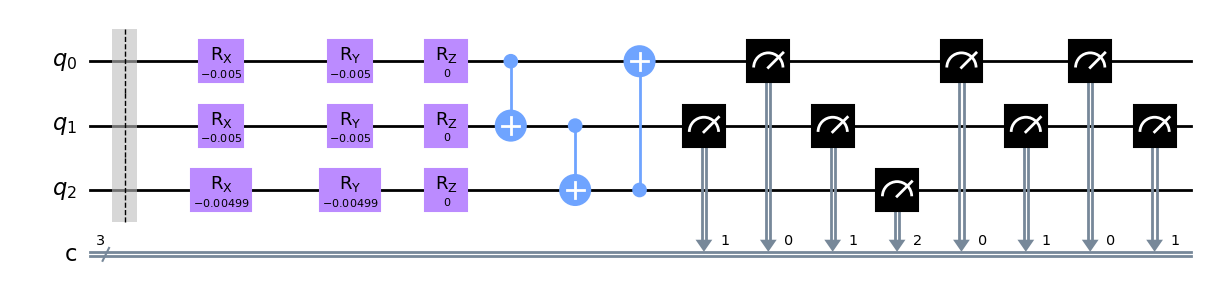

In [344]:
statevector.draw("mpl")

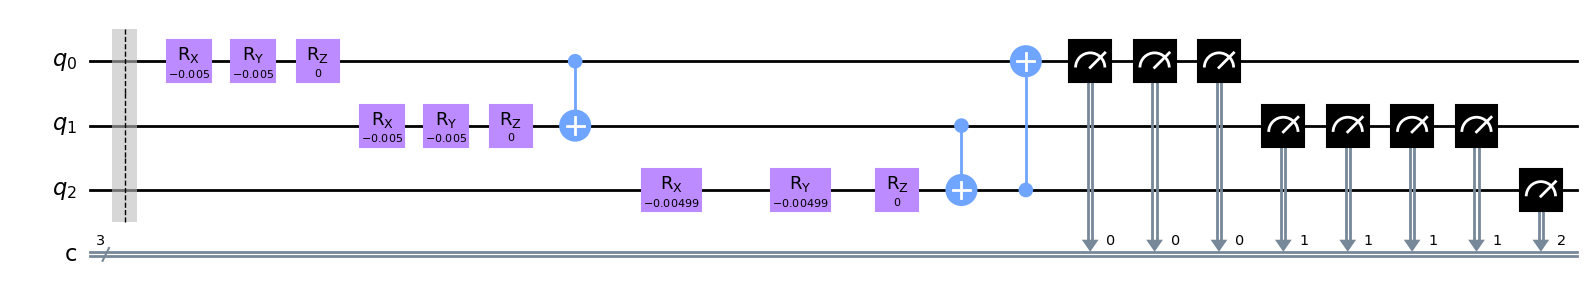

In [343]:
statevector.draw("mpl",justify="none")

In [ ]:
Hamiltonian_2()